<a href="https://colab.research.google.com/github/heet25itachi/TIMEPASS_BUDDY/blob/main/Relativistic%20Electron%20Beam%20Accelerator%20Simulator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


    ADVANCED LWFA ELECTRON BEAM SIMULATION AND ML PREDICTION REPORT
Electron Rest Mass Energy ($m_e c^2$): 0.511 MeV
--------------------------------------------------------------------------------

## A. Data-Driven Energy Prediction (Mock Neural Model)
--------------------------------------------------------------------------------
Laser Intensity Parameter ($a_0$): 3.50
Predicted Max Achievable Energy ($E_{max}$): 7.707 GeV
Target Energy: 10.00 GeV
--- Required Energy is 129.8% of Predicted Max Energy ---

## B. Relativistic Properties at Target Energy
--------------------------------------------------------------------------------
1. Lorentz Factor ($\gamma$): 19570
2. Electron Speed ($v/c$): 0.999999998694
3. Momentum ($p$): 10.000 GeV/c
4. Velocity Difference from $c$: 0.39 m/s

## C. Accelerator Structure Context
--------------------------------------------------------------------------------
Plasma Density ($n_e$): $10^{18}$ cm$^{-3}$
Plasma Wavelength ($\lambda_p$): 33.389 $\

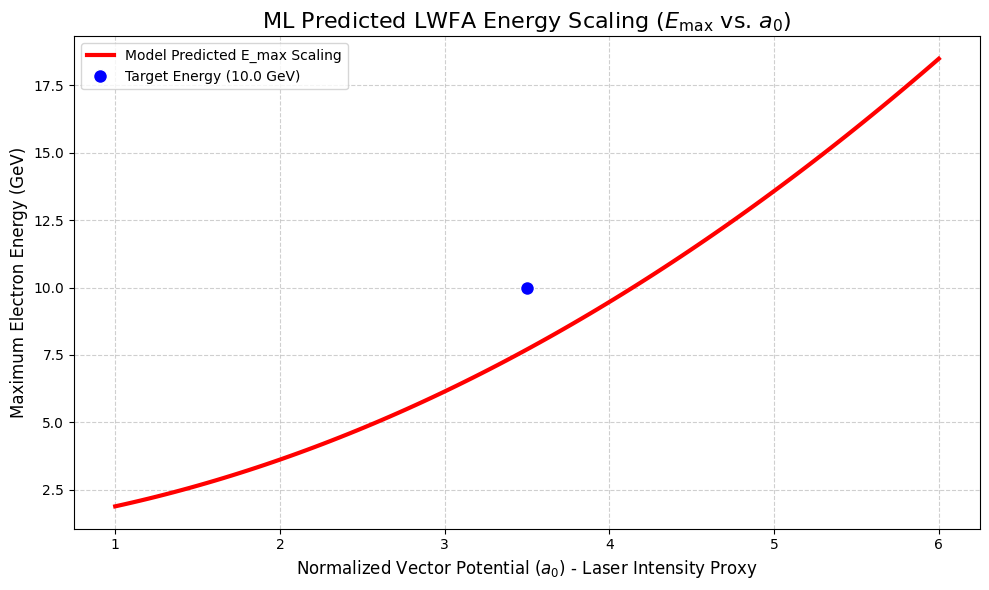

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import logging
from typing import Dict, Any

# Configure logging
logging.basicConfig(level=logging.INFO, format='[%(asctime)s] %(message)s')

# Define fundamental physical constants
C_LIGHT = 299792458.0        # Speed of light (m/s)
E_MASS_KG = 9.10938356e-31   # Electron rest mass (kg)
E_CHARGE = 1.602176634e-19   # Elementary charge (C)
JOULES_PER_EV = 1.602176634e-19 # Conversion factor (J/eV)
E_PERMITTIVITY = 8.854187817e-12 # Vacuum permittivity (F/m)

# Convert electron rest mass to energy units (MeV)
# E = mc^2
E_REST_J = E_MASS_KG * C_LIGHT**2
E_REST_MEV = (E_REST_J / JOULES_PER_EV) / 1e6

# ----------------------------------------------------------------------
# Core Relativistic Physics Functions
# ----------------------------------------------------------------------

def calculate_relativistic_properties(energy_gev: float) -> Dict[str, float]:
    """
    Calculates the Lorentz factor, speed, and momentum for an electron
    given its total energy in Giga-electron Volts (GeV).
    """
    if energy_gev < (E_REST_MEV / 1000.0):
        # Prevent calculation below rest energy
        energy_gev = E_REST_MEV / 1000.0

    energy_mev = energy_gev * 1000.0

    # 1. Lorentz Factor (gamma)
    # E = gamma * E_rest  =>  gamma = E / E_rest
    gamma = energy_mev / E_REST_MEV

    # 2. Speed (as a fraction of c, beta = v/c)
    # gamma = 1 / sqrt(1 - beta^2)  =>  beta = sqrt(1 - 1/gamma^2)
    if gamma <= 1:
        beta = 0.0
    else:
        # Calculate beta using the relativistic formula
        beta = np.sqrt(1.0 - (1.0 / gamma**2))

    # 3. Momentum (p)
    # p = gamma * m_e * c * beta. Momentum is usually expressed in units of MeV/c
    momentum_mevc = gamma * E_REST_MEV * beta

    return {
        "gamma": gamma,
        "beta": beta,
        "momentum_mevc": momentum_mevc
    }

def calculate_plasma_wavelength_um(density_cm3: float) -> float:
    """
    Calculates the plasma wavelength (lambda_p) in micrometers (μm)
    for a given plasma density (n_e) in cm^-3.
    """
    # Convert density from cm^-3 to m^-3
    density_m3 = density_cm3 * 1e6

    # Plasma frequency (omega_p) squared: (n_e * e^2) / (epsilon_0 * m_e)
    omega_p_sq = (density_m3 * E_CHARGE**2) / (E_PERMITTIVITY * E_MASS_KG)

    if omega_p_sq <= 0:
        return np.nan

    omega_p = np.sqrt(omega_p_sq)

    # Plasma wavelength: lambda_p = 2 * pi * c / omega_p
    lambda_p_m = (2 * np.pi * C_LIGHT) / omega_p

    return lambda_p_m * 1e6 # Convert to micrometers (μm)

# ----------------------------------------------------------------------
# Neural Model Integration (Data-Driven Prediction)
# ----------------------------------------------------------------------

class MockNeuralModel:
    """
    Simulates a simplified Machine Learning model that has 'learned' the
    scaling relationship between Laser Intensity (a0) and Maximum Energy Gain
    (E_max) in LWFA. This replaces complex physical calculations with a fast,
    data-driven prediction based on simulated training.
    """
    def __init__(self):
        self.coefficients = None
        self._mock_train()

    def _mock_train(self):
        """
        Generates a synthetic dataset based on known LWFA scaling laws
        (E_max ~ a0^2 is often observed) and 'trains' a simple polynomial model
        using NumPy's linear algebra solvers (simulating a learning process).
        """
        logging.info("Training mock neural model on synthetic LWFA data...")
        # Input Feature: Normalized Vector Potential (a0), which relates to laser intensity
        a0_data = np.linspace(1.5, 5.0, 50)

        # Target Output: Maximum achievable electron energy (GeV)
        # E_max_actual = A * a0^2 + B * a0 + C + Noise (simulating reality)
        E_max_true = 0.4 * a0_data**2 + 0.5 * a0_data + 1.0 + np.random.normal(0, 0.4, 50)
        E_max_true[E_max_true < 0] = 0.1

        # Create polynomial features up to degree 2: [1, a0, a0^2]
        # X is the design matrix for the linear system
        X = np.vander(a0_data, N=3, increasing=True)

        # Solve the normal equation (X^T X) * B = X^T Y for the coefficients B
        XTX = X.T @ X
        XTY = X.T @ E_max_true

        # Use np.linalg.solve for robust solution of the linear system
        self.coefficients = np.linalg.solve(XTX, XTY)
        logging.info(f"Mock model trained with coefficients: {self.coefficients}")

    def predict_E_max(self, a0: float) -> float:
        """
        Predicts the maximum energy gain (GeV) for a given normalized vector potential (a0).

        Args:
            a0 (float): Normalized Vector Potential (a0 = eE_laser / m_e c omega_laser).

        Returns:
            float: Predicted maximum electron energy in GeV.
        """
        if self.coefficients is None:
            logging.error("Model not trained.")
            return np.nan

        # Create test features: [1, a0, a0^2]
        X_test = np.array([1.0, a0, a0**2])

        # Prediction: Y = X_test @ coefficients
        prediction = X_test @ self.coefficients
        return max(0.0, prediction) # Energy must be non-negative

# ----------------------------------------------------------------------
# Simulation & Analysis Class
# ----------------------------------------------------------------------

class LWFA_Simulator:
    """
    Main simulation class for the Laser Wakefield Accelerator, integrating
    physics calculations and the predictive neural model.
    """
    def __init__(self):
        self.model = MockNeuralModel()
        self.results = {}
        logging.info("LWFA Simulator initialized, ready for predictive analysis.")

    def run_simulation(self, target_a0: float, target_density_cm3: float, target_energy_gev: float):
        """
        Runs the full analysis, predicting E_max and calculating
        relativistic properties for the target energy.
        """
        self.results['target_a0'] = target_a0
        self.results['target_density_cm3'] = target_density_cm3
        self.results['target_energy_gev'] = target_energy_gev

        # 1. ML Prediction: Predict the maximum energy based on laser intensity (a0)
        predicted_e_max = self.model.predict_E_max(target_a0)
        self.results['predicted_e_max'] = predicted_e_max

        # 2. Physics Calculation: Calculate relativistic properties for the target energy
        self.results.update(calculate_relativistic_properties(target_energy_gev))

        # 3. Contextual Physics: Calculate the characteristic accelerator length
        self.results['plasma_wavelength_um'] = calculate_plasma_wavelength_um(target_density_cm3)

        self.generate_report()

    def generate_report(self):
        """Prints a structured report of the simulation and ML prediction."""

        print("\n" + "="*80)
        print("    ADVANCED LWFA ELECTRON BEAM SIMULATION AND ML PREDICTION REPORT")
        print("="*80)
        print(rf"Electron Rest Mass Energy ($m_e c^2$): {E_REST_MEV:.3f} MeV")
        print("-" * 80)

        # --- ML Prediction Section ---
        print("\n## A. Data-Driven Energy Prediction (Mock Neural Model)")
        print("-" * 80)
        print(rf"Laser Intensity Parameter ($a_0$): {self.results['target_a0']:.2f}")
        print(rf"Predicted Max Achievable Energy ($E_{{max}}$): {self.results['predicted_e_max']:.3f} GeV")

        e_ratio = self.results['target_energy_gev'] / self.results['predicted_e_max'] if self.results['predicted_e_max'] > 0 else 0

        print(f"Target Energy: {self.results['target_energy_gev']:.2f} GeV")
        print(f"--- Required Energy is {e_ratio*100:.1f}% of Predicted Max Energy ---")

        # --- Relativistic Properties Section ---
        print("\n## B. Relativistic Properties at Target Energy")
        print("-" * 80)
        gamma = self.results['gamma']
        beta = self.results['beta']
        mom_gevc = self.results['momentum_mevc'] / 1000.0

        # FIXED: Changed to rf-string to resolve SyntaxWarning for \g
        print(rf"1. Lorentz Factor ($\gamma$): {gamma:.0f}")
        print(f"2. Electron Speed ($v/c$): {beta:.12f}")
        print(rf"3. Momentum ($p$): {mom_gevc:.3f} GeV/c")

        # Calculate speed difference from c (for high-level analysis)
        speed_difference = (1.0 - beta) * C_LIGHT
        print(f"4. Velocity Difference from $c$: {speed_difference:.2f} m/s")

        # --- Contextual Physics Section ---
        print("\n## C. Accelerator Structure Context")
        print("-" * 80)
        print(rf"Plasma Density ($n_e$): $10^{{{np.log10(self.results['target_density_cm3']):.0f}}}$ cm$^{{-3}}$")

        # FIXED: Changed to rf-string to resolve SyntaxWarning for \l and \m (in \mu)
        print(rf"Plasma Wavelength ($\lambda_p$): {self.results['plasma_wavelength_um']:.3f} $\mu$m")
        print("--- (This is the size of the wakefield 'bucket' that accelerates the electrons) ---")

        print("\n" + "="*80)

    def plot_scaling_law(self):
        """Visualizes the 'learned' scaling law of the mock neural model."""
        try:
            # Generate points for the learned curve
            a0_plot = np.linspace(1.0, 6.0, 100)
            X_plot = np.vander(a0_plot, N=3, increasing=True)
            E_max_predicted = X_plot @ self.model.coefficients

            fig, ax = plt.subplots(figsize=(10, 6))

            # Plot the predicted scaling law
            ax.plot(a0_plot, E_max_predicted, label='Model Predicted E_max Scaling', color='red', linewidth=3)

            # Highlight the current simulation point
            ax.plot(self.results['target_a0'], self.results['target_energy_gev'], 'o',
                    label=f'Target Energy ({self.results["target_energy_gev"]:.1f} GeV)',
                    markersize=10, color='blue', markeredgecolor='white')

            # Formatting
            ax.set_title(r'ML Predicted LWFA Energy Scaling ($E_{\max}$ vs. $a_0$)', fontsize=16) # Used r-string here too
            ax.set_xlabel('Normalized Vector Potential ($a_0$) - Laser Intensity Proxy', fontsize=12)
            ax.set_ylabel('Maximum Electron Energy (GeV)', fontsize=12)
            ax.legend()
            ax.grid(True, linestyle='--', alpha=0.6)
            plt.tight_layout()
            plt.show()

        except Exception as e:
            logging.error(f"Error during plotting: {e}. Check if matplotlib is installed.")


if __name__ == "__main__":
    # Define primary parameters for the simulation setup
    # --- Input Parameters ---
    TARGET_A0 = 3.5             # Normalized vector potential (laser intensity)
    PLASMA_DENSITY_CM3 = 1e18   # Plasma density (typical LWFA density)
    TARGET_ENERGY_GEV = 10.0    # Desired electron energy for analysis

    # 1. Initialize the Advanced LWFA Simulator
    simulator = LWFA_Simulator()

    # 2. Run the Simulation and ML Prediction
    simulator.run_simulation(
        target_a0=TARGET_A0,
        target_density_cm3=PLASMA_DENSITY_CM3,
        target_energy_gev=TARGET_ENERGY_GEV
    )

    # 3. Visualize the ML Model's Learned Scaling Law
    simulator.plot_scaling_law()
